## Estimating Home Prices with SLR using TensorFlow and Keras

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
%matplotlib inline

### Import data

In [2]:
column_names = ['serial', 'date', 'age', 'distance', 'stores', 'latitude', 'longitude', 'price']
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


In [3]:
#check for any missing values in the data
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

### Make it easier for the optimization algorithm to execute by normalizing the data

In [4]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


### Convert the predicted values back to the original distribution to get predicted prices

In [5]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

### Create training and test sets

In [6]:
#remove the column price from the list of features so it's not used as an actual feature.
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


### Select labels

In [7]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

In [8]:
#extract just the numeric values for the features and labels since TensorFlow will only accept these
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


### Train-Test-Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, 
                                                    shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


### Create the Model

##### A Sequential model in Keras is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. This is what I will use below.

In [10]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adam'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Epoch 1/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.6017 - val_loss: 0.4251
Epoch 2/1000
149/149 [==============================] - 0s 940us/step - loss: 0.4646 - val_loss: 0.3446
Epoch 3/1000
149/149 [==============================] - 0s 935us/step - loss: 0.3953 - val_loss: 0.2916
Epoch 4/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.3443 - val_loss: 0.2508
Epoch 5/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.3054 - val_loss: 0.2267
Epoch 6/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2754 - val_loss: 0.2097
Epoch 7/1000
149/149 [==============================] - 0s 2ms/step - loss: 0.2524 - val_loss: 0.1918
Epoch 8/1000
149/149 [==============================] - 0s 1ms/step - loss: 0.2340 - val_loss: 0.1805
Epoch 9/1000
149/149 [==============================] - 0s 969us/step - loss: 0.2194 - val_loss: 0.1795
Epoch 10/1000
149/149 [==============================] - 0s 983us/step - los

###  Plot Training and Validation Loss

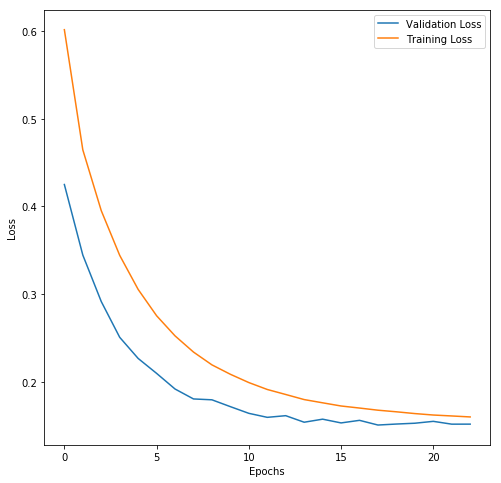

In [12]:
h = history.history
x_lim = len(h['loss'])
plt.figure(figsize=(8, 8))
plt.plot(range(x_lim), h['val_loss'], label = 'Validation Loss')
plt.plot(range(x_lim), h['loss'], label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot Price Predictions

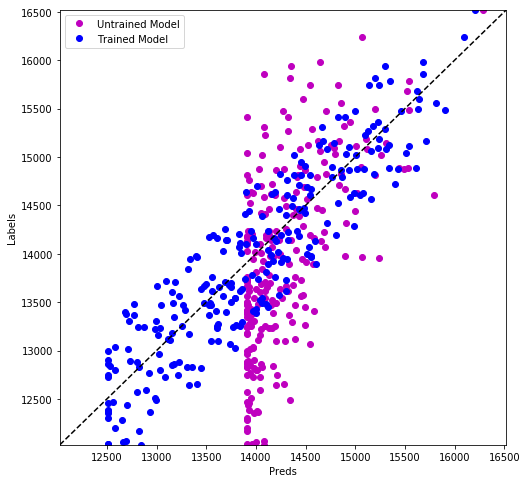

In [13]:
preds_on_trained = model.predict(X_test)
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]


plt.figure(figsize=(8, 8))
plt.plot(price_on_untrained, price_y_test, 'mo', label='Untrained Model')
plt.plot(price_on_trained, price_y_test, 'bo', label='Trained Model')
plt.xlabel('Preds')
plt.ylabel('Labels')
    
y_min = min(min(price_y_test), min(price_on_untrained), min(price_on_trained))
y_max = max(max(price_y_test), max(price_on_untrained), max(price_on_trained))
    
plt.xlim([y_min, y_max])
plt.ylim([y_min, y_max])
plt.plot([y_min, y_max], [y_min, y_max], 'k--')
plt.legend()
plt.show()

